### SVD

Text(0.5, 1.0, 'explained variance')

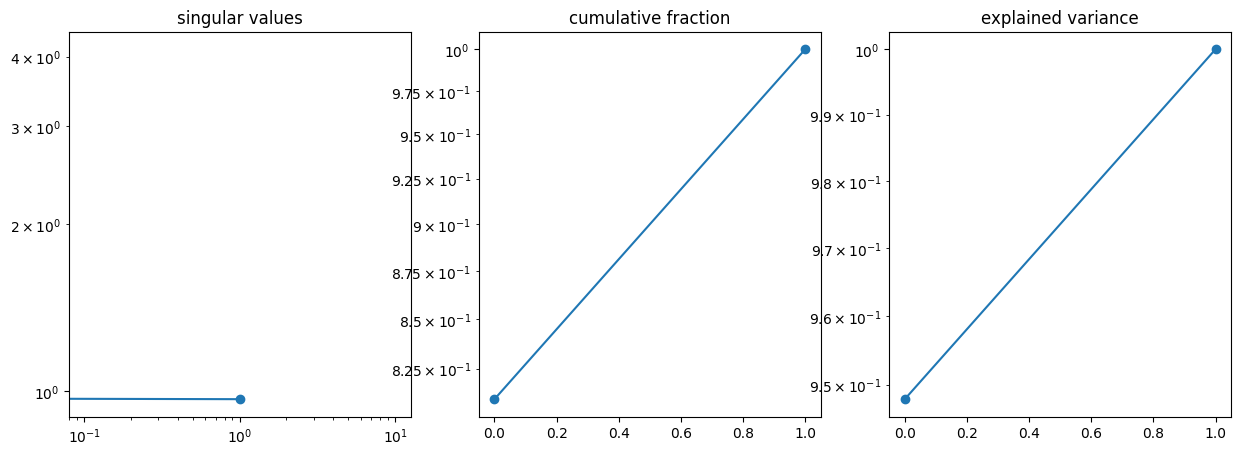

In [5]:
import numpy as np
import matplotlib.pyplot as plt
A=np.array([[2,2], [1,3]])

U,s, VT = np.linalg.svd(A, full_matrices=False)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].loglog(s, "o-")
axs[0].set_title("singular values")
axs[1].semilogy(np.cumsum(s) / np.sum(s), "o-")
axs[1].set_title("cumulative fraction")
axs[2].semilogy(np.cumsum(s**2) / np.sum(s**2), "o-")
axs[2].set_title("explained variance")

- Compute the reconstruction error of the dataset as a function of $k$.

```python
U, s, VT = np.linalg.svd(A_norm, full_matrices=False)

reconstruction_error = list()
ks = np.array()

for k in ks:
    A_k = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    reconstruction_error.append(np.linalg.norm(A_norm - A_k, ord=2))

---

#### **Reconstruction Error**

Reconstruction error measures how well a reduced representation of the data (using fewer principal components) approximates the original data. It is calculated as the difference between the original dataset $A_{\text{bar}}$ and the approximated dataset $A_k$, which is reconstructed using only the top $k$ singular values and vectors.

The error is computed as:
$$
\text{Reconstruction Error} = \| A_{\text{bar}} - A_k \|_2
$$

Here:
- $A_{\text{bar}}$: The original normalized dataset.
- $A_k$: The reconstructed dataset using $k$ principal components.

#### **3. `ord=2` in `np.linalg.norm`**

In `np.linalg.norm`, the parameter `ord` specifies the type of norm to compute. When `ord=2`:
- It computes the **spectral norm** (largest singular value of the difference matrix).
- Mathematically, it is:
$$
\| A_{\text{bar}} - A_k \|_2 = \sigma_{\text{max}}
$$
where $\sigma_{\text{max}}$ is the largest singular value of $A_{\text{bar}} - A_k$.

In this context, `ord=2` provides a measure of the largest deviation between the original data and the reconstructed data along any dimension.

- It aligns with the concept of variance maximization along principal components.
- It ensures the reconstruction error focuses on the direction with the largest error, providing a conservative measure of reconstruction quality.

---

### Compress Image and Reconstruction Error

In [3]:
import numpy as np
# Compute the exact SVD of the grayscale image matrix

# Function to compress the image and calculate the reconstruction error
def compress_image(U, s, VT, k, original_img):
    # Take the first k singular values/vectors to compress the image
    S_k = np.diag(s[:k])
    U_k = U[:, :k]
    VT_k = VT[:k, :]
    
    # Reconstruct the image with rank k
    compressed_img = U_k @ S_k @ VT_k
    
    # Compute the reconstruction error using the matrix 2-norm
    error = np.linalg.norm(original_img - compressed_img, ord=2)
    
    return compressed_img, error

NameError: name 'A' is not defined

---

### Reconstruction Error, Missing Variance, and Total Variance in SVD

When approximating a matrix $ \mathbf{X} $ using the truncated SVD of rank $ r $, the approximation $ \tilde{\mathbf{X}} $ introduces some error. The **reconstruction error** is defined as:
$$
\text{Reconstruction Error} = \frac{\|\mathbf{X} - \tilde{\mathbf{X}}\|_F}{\|\mathbf{X}\|_F},
$$
where:
- $ \|\mathbf{X} - \tilde{\mathbf{X}}\|_F $: Frobenius norm of the difference between the original matrix $ \mathbf{X} $ and the approximation $ \tilde{\mathbf{X}} $.
- $ \|\mathbf{X}\|_F $: Frobenius norm of the original matrix $ \mathbf{X} $.

The reconstruction error is a value between $ 0 $ and $ 1 $, representing how much information is **not captured** by the rank-$ r $ approximation.

#### Missing Variance
The **missing variance** is the square of the reconstruction error:
$$
\text{Missing Variance} = \left(\frac{\|\mathbf{X} - \tilde{\mathbf{X}}\|_F}{\|\mathbf{X}\|_F}\right)^2.
$$
This represents the proportion of variance in the original matrix $ \mathbf{X} $ that is **not explained** by the truncated SVD.

#### Total Variance
The **total variance** of the matrix $ \mathbf{X} $ is related to the Frobenius norm:
$$
\|\mathbf{X}\|_F^2 = \sum_{i=1}^n \sigma_i^2,
$$
where $ \sigma_i $ are the singular values of $ \mathbf{X} $. The retained variance for a truncated SVD with rank $ r $ is given by:
$$
\text{Retained Variance} = \frac{\sum_{i=1}^r \sigma_i^2}{\sum_{i=1}^n \sigma_i^2}.
$$
The missing variance can also be computed as:
$$
\text{Missing Variance} = 1 - \text{Retained Variance}.
$$

#### Finding the Rank for 99% Variance
To find the rank $ \tilde{r} $ that captures at least 99% of the variance in the original matrix, you solve for the smallest $ \tilde{r} $ such that:
$$
\frac{\sum_{i=1}^{\tilde{r}} \sigma_i^2}{\sum_{i=1}^n \sigma_i^2} \geq 0.99.
$$
This ensures that the approximation retains at least 99% of the variance while minimizing the missing variance.

### Steps to Solve the Problem
1. **Compute the Economy SVD**: Perform the SVD of $ \mathbf{X} $ and compute the singular values $ \sigma_i $.
2. **Calculate Reconstruction Error**:
   - For different ranks $ r $, compute the relative reconstruction error:
     $$
     \frac{\|\mathbf{X} - \tilde{\mathbf{X}}\|_F}{\|\mathbf{X}\|_F}.
     $$
3. **Square the Error**: Square the reconstruction error to compute the missing variance:
   $$
   \text{Missing Variance} = \left(\text{Reconstruction Error}\right)^2.
   $$
4. **Find $ \tilde{r} $**: Identify the rank $ \tilde{r} $ such that the retained variance is at least 99%, or equivalently, the missing variance is less than 0.01.



```python
low_ranks = np.arange(10, 300, 1)
for r in low_ranks:
    X_tilde = U[:, :r] @ np.diag(s[:r]) @ VT[:r, :]
    unexplained_variance = reconstruction_error(X, X_tilde)**2
    if unexplained_variance <= 0.01:
        searched_rank = r
        break
print('searched rank is: ', r)
print('explained variance is: ', 1 - unexplained_variance)


---

### PCA

The Principal Component Analysis is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional representation, by means of linear combinations of vectors that are directed in the directions where variance is maximized, in descending order: this means that the vector related to the first principal component is the direction of maximum variance in the dataset, the vector related to the second principal component is the second direction where variance is maximized, and so on.

Here are the steps required to perform PCA:
- Center (or standardize) the data: move to a dataset where each feature has zero mean (and unit variance if standardized);
- Compute the covariance matrix of the centered (standardized) data: $$ C = \frac{A^TA}{n-1}$$ with $n$ number of samples;
- Find eigenvectors and eigenvalues of the covariance matrix: $C$ is symmetric, so it can be diagonalized $$C = WLW^T$$ Eigenvectors are in matrix $W$ and represent the principal components (direction of maximum variance), and the eigenvalues are in the diagonal matrix $L$ and indicate the amount of variance explained by each principal component (the magnitude of the variance). 

    Eigenvectors are all orthogonal to each other, and the corresponding eigenvalues are sorted in descending order;
- Project the data onto the new feature space: principal components for the data are given by $AV$. 

    The new features will be a linear combination of the original features. The projection matrix is obtained by stacking the eigenvectores corresponding to the selected principal components (i.e., the ones that together explain the majority of the variance in the dataset). The new dataset is obtained by multiplying the standardized data by the projection matrix.

The SVD can be used in this process by modifying a little bit the steps:
- Instead of computing the covariance matrix of the centered (standardized) data, apply the SVD decomposition on it: $$A = U\Sigma V^T$$
 Matrix $U$ contains the left singular vectors, matrix $V^T$ contains the right singular vectors, while matrix $\Sigma$ is diagonal and contains the singular values.
 We can easily see that $$C = \frac{V\Sigma U^TU\Sigma V^T}{n-1} = V\frac{\Sigma ^2}{n-1}V^T$$ so right singular vectors $V$ are principal components and singular values are related to eigenvalues of the covariance matrix by $\lambda _i = \frac{\sigma _i ^2}{n-1} $ .
- Principal components are then obtained by multiplying $AV = U\Sigma V^TV = U\Sigma$

### Perform PCA on the dataset by means of the SVD decomposition. Then, plot the trend of:
- The **singular values**: $$\sigma_k$$
- The **cumulate fraction of singular values**: $$\frac{\sum_{i=1}^k \sigma_i}{\sum_{i=1}^q \sigma_i}$$
- The **fraction of the explained variance**: $$\frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^q \sigma_i^2}$$

```python
A_norm = (A - np.mean(A, axis=1)[:,None]) / np.std(A, axis=1)[:,None]
U, s, VT = np.linalg.svd(A_norm, full_matrices=False)

fig, axes = plt.subplots(1, 3, figsize = (18,6))

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singular Values')

axes[1].plot(np.cumsum(s) / np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')

axes[2].plot(np.cumsum(s**2) / np.sum(s**2), 'o-')
axes[2].set_title('Explained Variance')

### Generate a scatterplot of the first two principal components of the dataset, grouped by label.

```python
for g in groups:
  plt.scatter(Phi[0, labels == g], Phi[1, labels == g], label = g)
plt.xlabel('1st p.c.')
plt.ylabel('2nd p.c.')
plt.legend()

---

### rSVD

Randomized SVD (RSVD) is a computationally efficient alternative to traditional SVD, particularly useful for large datasets. RSVD approximates the singular values and singular vectors of a matrix by projecting the data onto a lower-dimensional subspace, reducing the computational cost.

rsvd is a quick way of computing A reduced version of the SVD when you don't want all the singular values in the associated singular values, but just those up to some rank K

```python
def randomized_SVD(A, k):
  m, n = A.shape
  P = np.random.randn(n, k) #generates random numbers according to the standard normal distribution
  '''
  you want to extract 
  the most prominent features 
  that are in the columns
  '''
  Z = A @ P
  Q, R = np.linalg.qr(Z)
  Y = Q.T @ A # QR factorization
  Uy, sy, VTy = np.linalg.svd(Y, full_matrices = False)
  U = Q @ Uy
  return U, sy, VTy


### GENERAL RSVD COMMENTS


# Analysis of Singular Values for Different Methods

1. **Exact SVD**:
   - The exact SVD (blue curve) displays all singular values, decreasing smoothly and steadily. 
   - This curve represents the true singular value spectrum of the data matrix.

2. **Randomized SVD**:
   - The curves for randomized SVD with ranks $k = 25, 50, 100, 200, 400$ (orange, green, red, purple, brown) closely match the beginning of the exact singular value spectrum.
   - As $k$ increases, the approximation improves and extends further into the spectrum.
   - For smaller $k$ values (e.g., $k=25, k=50$), the randomized SVD captures only the leading singular values (high variance components) and truncates the rest.

3. **Logarithmic Scale**:
   - The semilogarithmic scale clearly shows the decay of singular values. This highlights how the randomized SVD approximates the leading singular values well, while the tail (lower singular values) is ignored for small $k$.

## Conclusion
- **Effectiveness of Randomized SVD**:
  - Randomized SVD is effective in approximating the leading singular values, making it a computationally efficient alternative for large-scale matrices.
  - For small $k$, the reconstruction will focus only on the dominant components, which may suffice for dimensionality reduction tasks.

- **Trade-Off with $k$**:
  - Higher $k$ provides better approximation but at increased computational cost. Selecting $k$ depends on the desired balance between accuracy and efficiency.

The plot highlights the trade-off between rank approximation and computational resources, providing insight into how randomized SVD performs relative to exact SVD for different ranks.


### RSVD with oversampling


In RSVD, oversampling involves adding extra dimensions (columns) to the random projection matrix used to approximate the input matrix. The purpose of oversampling is to improve the accuracy of the approximation by ensuring that important features of the input matrix are not lost.

1. **Random Projection Matrix**:
   - RSVD starts by generating a random projection matrix $P$ with dimensions $n \times (k + p)$, where:
     - $k$: Target rank (number of singular values/vectors desired).
     - $p$: Oversampling parameter (additional dimensions added to $P$).
   - $p$ helps capture variability that might otherwise be missed if the rank $k$ is too small.

2. **Oversampling Formula**:
   $$
   p = \lceil 0.5k \rceil
   $$
   - 50% more dimensions than the target rank $k$ are added to ensure better approximation.

3. **Steps in RSVD with Oversampling**:
   - Generate a random matrix $P$ of size $n \times (k + p)$.
   - Form the projected matrix $B = A P$, where $A$ is the input matrix.
   - Perform SVD on the smaller matrix $B$ to approximate the singular values and singular vectors of $A$.



```python
# default oversampling_size=1.5 is 50% of oversampling
def randomized_SVD_oversampling(A, k, oversampling_size=1.5):
    np.random.seed(random_seed)
    m, n = A.shape
    # create a random matrix
    omega = np.random.rand(n, round(k * oversampling_size))
    Y = A @ omega
    Q, R = np.linalg.qr(Y)
    B = Q.T @ A
    # perform the SVD on B
    rU, rs, rVT = np.linalg.svd(B, full_matrices=False)
    # recover left singular values
    rU = Q @ rU
    return rU, rs, rVT

### General comments of what we see/achieve

- We can see that as the rank k of the randomized SVD algorithm increases, the approximation of the singular values becomes more and more accurate.
There is an overall underestimation of the singular values (i.e. less variability is captured), but the approximation is still very good.

In [6]:
import time

t0 = time.time()
U, s, VT = np.linalg.svd(A, full_matrices=False)
t1 = time.time()
exact_time = t1 - t0
print("Exact SVD took %f seconds" % exact_time)

Exact SVD took 0.000000 seconds


```python
t0 = time.time()
rU, rs, rVT = randomized_SVD(A, 200)
t1 = time.time()
rand_time = t1 - t0
print("Randomized SVD took %f seconds" % rand_time)

```python
t0 = time.time()
rU, rs, rVT = randomized_SVD_oversampling(A, 200)
t1 = time.time()
rand_time = t1 - t0
print("Randomized SVD took %f seconds" % rand_time)

---

### SVT 

To reconstruct images

In [3]:
import numpy as np
mask_keep = [] #implement it to know which elements are correct, and so we need to keep
def SVT(img_ch, s_treshold):
    max_iter= 200
    tol= 1.0e-6

    img = img_ch.copy() # to copy without creating a references (because if not when we modify x hat we modify also x full)
    for k in range(max_iter):
        img_old = img.copy() # A copy of the current X_hat to track changes between iterations
        U,s,VT = np.linalg.svd(img, full_matrices = False)
        s[s < s_treshold] = 0 #mask for thresholding, so we can get rid of the singular values below the threshold
        img = U @ np.diag(s) @ VT # reconstuct using the multiplication of the components of the svd with the sigma truncated
        img[mask_keep] = img_ch[mask_keep] #put in the positions where we have the data, the correct data 
        increment = np.linalg.norm(img - img_old)

        if increment < tol:
            print("Toleranche achieved!")
            break

        print('======= iteration %d (increment %1.2e)' % (k, increment))

    return img